# <span style="color: #2E86C1;">Paraphrase Identification with Deep Learning</span>
This project implements **paraphrase identification** using the **Quora Question Pairs** dataset.

It includes multiple models from the review paper:
- <span style="color: #28B463;">Feedforward Neural Network (FFN)</span>
- <span style="color: #28B463;">Bi-LSTM with Gated Relevance Network (GRN)</span>
- <span style="color: #28B463;">Siamese Network</span>
- <span style="color: #28B463;">CNN</span>

We compare these models based on evaluation metrics:
- <span style="color: #D4AC0D;">Accuracy</span>
- <span style="color: #D4AC0D;">F1-Score</span>
- <span style="color: #D4AC0D;">Precision</span>
- <span style="color: #D4AC0D;">Recall</span>

# 1. Importing Necessary Libraries

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, Conv1D, GlobalMaxPooling1D, Subtract, Multiply, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

# 2. Loading and Preprocessing the Dataset

In [ ]:
# Load the dataset
from google.colab import files
upload = files.upload()

Saving questions.csv to questions.csv


In [ ]:
data = pd.read_csv("questions.csv", nrows=10000)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Text preprocessing

In [ ]:
import spacy
sp = spacy.load('en_core_web_sm')

In [ ]:
def clean_question(text):
    doc = sp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and len(token) > 1]
    return ' '.join(tokens)

In [ ]:
data["question1"] = data["question1"].apply(clean_question)
data["question2"] = data["question2"].apply(clean_question)

In [ ]:
# Display cleaned data
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what be the step by step guide to invest in sh...,what be the step by step guide to invest in sh...,0
1,1,3,4,what be the story of kohinoor koh noor diamond,what would happen if the indian government ste...,0
2,2,5,6,how can increase the speed of my internet conn...,how can internet speed be increase by hack thr...,0
3,3,7,8,why be mentally very lonely how can solve it,find the remainder when be divide by,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


# Tokenization and padding

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data["question1"].tolist() + data["question2"].tolist())
vocab_size = len(tokenizer.word_index) + 1
max_len = 128

In [ ]:
def tokenize_and_pad(text):
    sequences = tokenizer.texts_to_sequences(text)
    return pad_sequences(sequences, maxlen=max_len)

In [ ]:
q1_sequences = tokenize_and_pad(data["question1"].tolist())
q2_sequences = tokenize_and_pad(data["question2"].tolist())
labels = data["is_duplicate"].values

In [ ]:
# Split the dataset
X_train_q1, X_test_q1, X_train_q2, X_test_q2, y_train, y_test = train_test_split(
    q1_sequences, q2_sequences, labels, test_size=0.2, random_state=42
)

# 3. Loading Pre-trained Word Embeddings (GloVe)

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -P ./glove/

--2024-12-08 15:00:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-08 15:00:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-08 15:00:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘./glove/glove.6B.zi

In [ ]:
!unzip ./glove/glove.6B.zip -d ./glove/

Archive:  ./glove/glove.6B.zip
  inflating: ./glove/glove.6B.50d.txt  
  inflating: ./glove/glove.6B.100d.txt  
  inflating: ./glove/glove.6B.200d.txt  
  inflating: ./glove/glove.6B.300d.txt  


In [ ]:
import os
print(os.listdir('./glove'))

['glove.6B.200d.txt', 'glove.6B.100d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.zip']


In [ ]:
glove_path = './glove/glove.6B.200d.txt'

# Load GloVe embeddings
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if word in tokenizer.word_index:
            embedding_matrix[tokenizer.word_index[word]] = coefs

# 4. Model Architectures

### 4.1 Feedforward Neural Network (FFN)



In [ ]:
def build_ffn_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    input_q1 = Input(shape=(max_len,))
    input_q2 = Input(shape=(max_len,))

    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
    embedded_q1 = embedding_layer(input_q1)
    embedded_q2 = embedding_layer(input_q2)

    flat_q1 = Flatten()(embedded_q1)
    flat_q2 = Flatten()(embedded_q2)

    merged = Concatenate()([flat_q1, flat_q2])
    dense = Dense(128, activation='relu')(merged)
    dropout = Dropout(0.3)(dense)
    output = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=[input_q1, input_q2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 4.2 Bi-LSTM with Gated Relevance Network (GRN)

In [ ]:
def build_bilstm_grn_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    input_q1 = Input(shape=(max_len,))
    input_q2 = Input(shape=(max_len,))

    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
    lstm_layer = Bidirectional(LSTM(50, return_sequences=True))

    encoded_q1 = lstm_layer(embedding_layer(input_q1))
    encoded_q2 = lstm_layer(embedding_layer(input_q2))

    attention = tf.keras.layers.Attention()([encoded_q1, encoded_q2])
    flat = Flatten()(attention)
    dense = Dense(128, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_q1, input_q2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 4.3 Siamese Network

In [ ]:
def build_siamese_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    input_q1 = Input(shape=(max_len,))
    input_q2 = Input(shape=(max_len,))

    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
    lstm_layer = LSTM(50)

    encoded_q1 = lstm_layer(embedding_layer(input_q1))
    encoded_q2 = lstm_layer(embedding_layer(input_q2))

    subtracted = Subtract()([encoded_q1, encoded_q2])
    multiplied = Multiply()([encoded_q1, encoded_q2])

    merged = Concatenate()([subtracted, multiplied])
    dense = Dense(128, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_q1, input_q2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 4.4 CNN



In [ ]:
def build_cnn_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    input_q1 = Input(shape=(max_len,))
    input_q2 = Input(shape=(max_len,))

    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
    cnn_layer = Conv1D(128, kernel_size=5, activation='relu')
    pooling_layer = GlobalMaxPooling1D()

    encoded_q1 = pooling_layer(cnn_layer(embedding_layer(input_q1)))
    encoded_q2 = pooling_layer(cnn_layer(embedding_layer(input_q2)))

    merged = Concatenate()([encoded_q1, encoded_q2])
    dense = Dense(128, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_q1, input_q2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5. Training and Evaluation of Models

In [ ]:
def train_and_evaluate(model, X_train_q1, X_train_q2, y_train, X_test_q1, X_test_q2, y_test, model_name):
    # Update file path to use `.keras` extension
    checkpoint_path = f'{model_name}.keras'

    # Define callbacks
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
    callbacks = [checkpoint, reduce_lr, early_stopping]

    # Train the model
    history = model.fit(
        [X_train_q1, X_train_q2], y_train,
        validation_data=([X_test_q1, X_test_q2], y_test),
        epochs=10,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    # Load the best model
    model.load_weights(checkpoint_path)

    # Evaluate the model
    y_pred = (model.predict([X_test_q1, X_test_q2]) > 0.5).astype(int).flatten()
    report = classification_report(y_test, y_pred, target_names=['Not Duplicate', 'Duplicate'], output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Classification Report for {model_name}:")
    print(pd.DataFrame(report))
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)

    return history, report, conf_matrix

# 6. Training All Models

In [ ]:
# Train and evaluate FFN
ffn_model = build_ffn_model(vocab_size, embedding_dim, max_len, embedding_matrix)
ffn_history, ffn_report, ffn_conf_matrix = train_and_evaluate(
    ffn_model, X_train_q1, X_train_q2, y_train, X_test_q1, X_test_q2, y_test, "FFN_Model"
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6387 - loss: 0.6411 - val_accuracy: 0.6715 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7164 - loss: 0.5461 - val_accuracy: 0.6735 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7588 - loss: 0.4846 - val_accuracy: 0.6795 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8015 - loss: 0.4119 - val_accuracy: 0.6485 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8686 - loss: 0.3281 - val_accuracy: 0.6530 - val_loss: 0.6851 - learning_rate: 2.0000e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report for FFN_Model:
           Not Duplicate   Duplicate  accuracy    macro avg  weighted avg
precision       0.699472    0.592593    0.6735     0.646032      0.659766
recall     

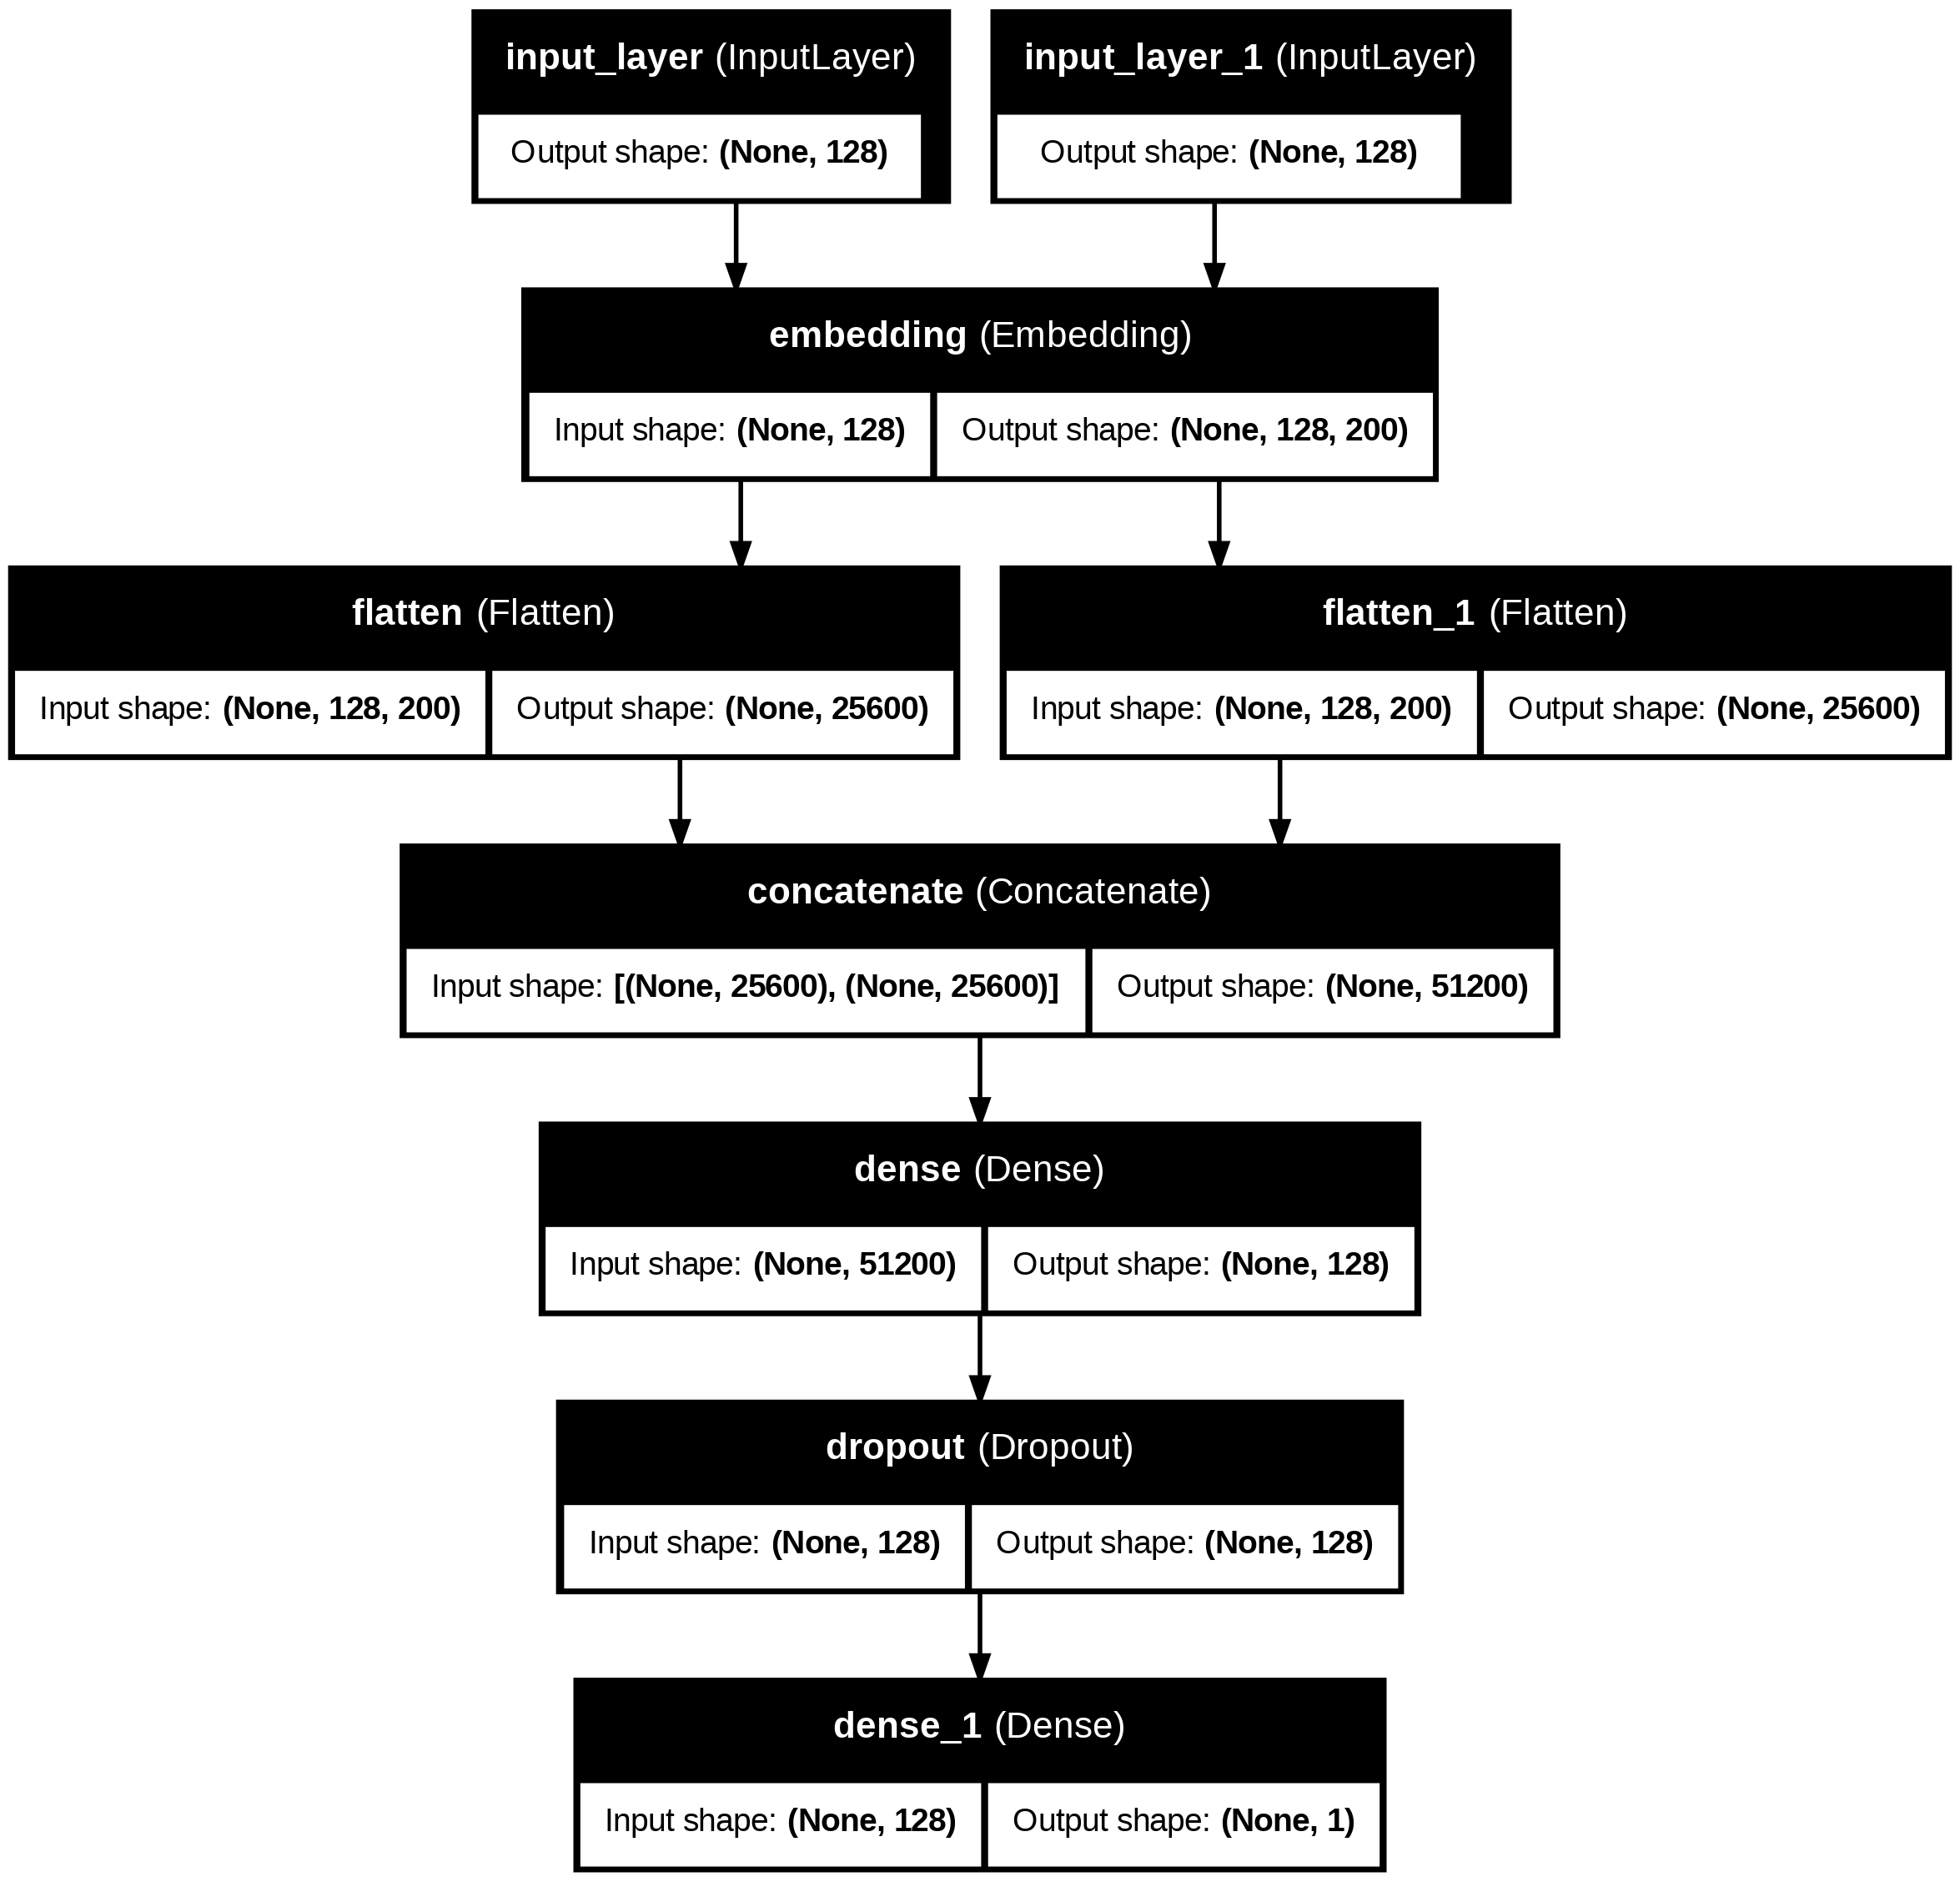

In [ ]:
plot_model(ffn_model, to_file='ffn_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train and evaluate Bi-LSTM + GRN
bilstm_grn_model = build_bilstm_grn_model(vocab_size, embedding_dim, max_len, embedding_matrix)
bilstm_grn_history, bilstm_grn_report, bilstm_grn_conf_matrix = train_and_evaluate(
    bilstm_grn_model, X_train_q1, X_train_q2, y_train, X_test_q1, X_test_q2, y_test, "BiLSTM_GRN_Model"
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.6296 - loss: 0.6492 - val_accuracy: 0.6580 - val_loss: 0.6071 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6821 - loss: 0.5808 - val_accuracy: 0.6905 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7270 - loss: 0.5261 - val_accuracy: 0.6890 - val_loss: 0.5656 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7562 - loss: 0.4791 - val_accuracy: 0.7210 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7868 - loss: 0.4356 - val_accuracy: 0.7160 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8248 - loss: 0.3715 - val_accuracy: 0.7245 - val_loss: 0.5927 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8527 - loss: 0

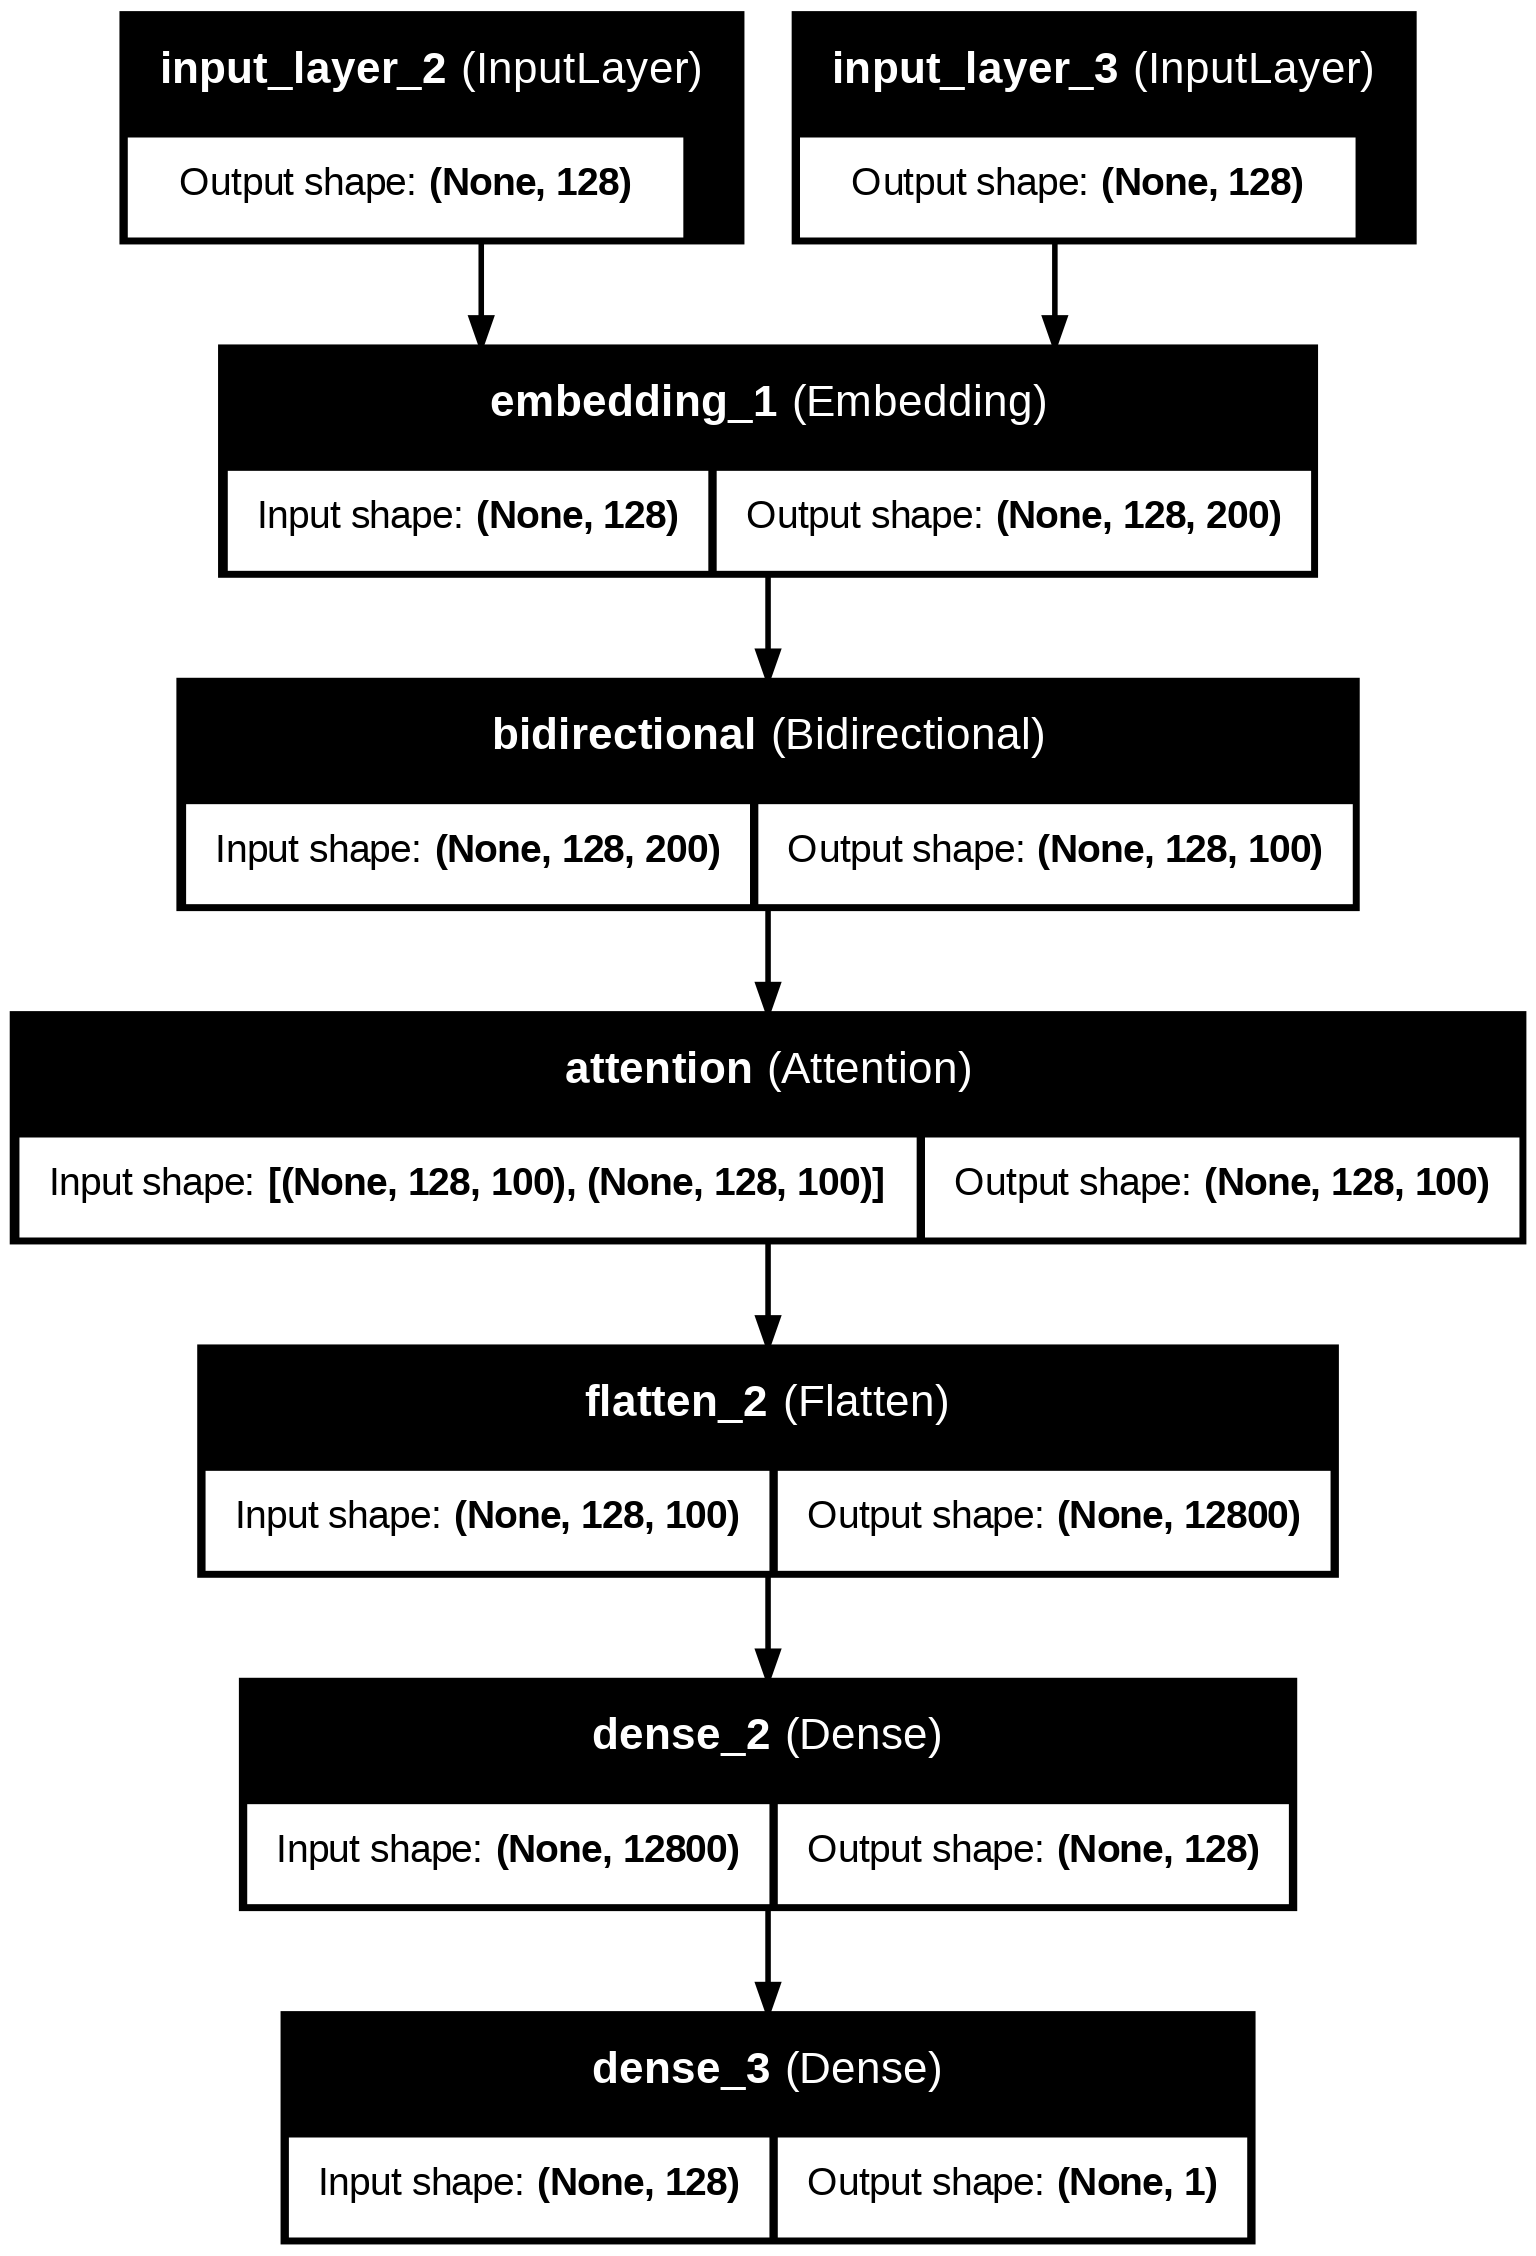

In [ ]:
plot_model(bilstm_grn_model, to_file='bilstm_grn_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train and evaluate Siamese Network
siamese_model = build_siamese_model(vocab_size, embedding_dim, max_len, embedding_matrix)
siamese_history, siamese_report, siamese_conf_matrix = train_and_evaluate(
    siamese_model, X_train_q1, X_train_q2, y_train, X_test_q1, X_test_q2, y_test, "Siamese_Model"
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6149 - loss: 0.6509 - val_accuracy: 0.6980 - val_loss: 0.5882 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6967 - loss: 0.5555 - val_accuracy: 0.7210 - val_loss: 0.5595 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7594 - loss: 0.4795 - val_accuracy: 0.7200 - val_loss: 0.5573 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7843 - loss: 0.4414 - val_accuracy: 0.7245 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8256 - loss: 0.3808 - val_accuracy: 0.7170 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8579 - loss: 0.3332 - val_accuracy: 0.7200 - val_loss: 0.5970 - learning_rate: 2.0000e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report for Siamese_Model:
         

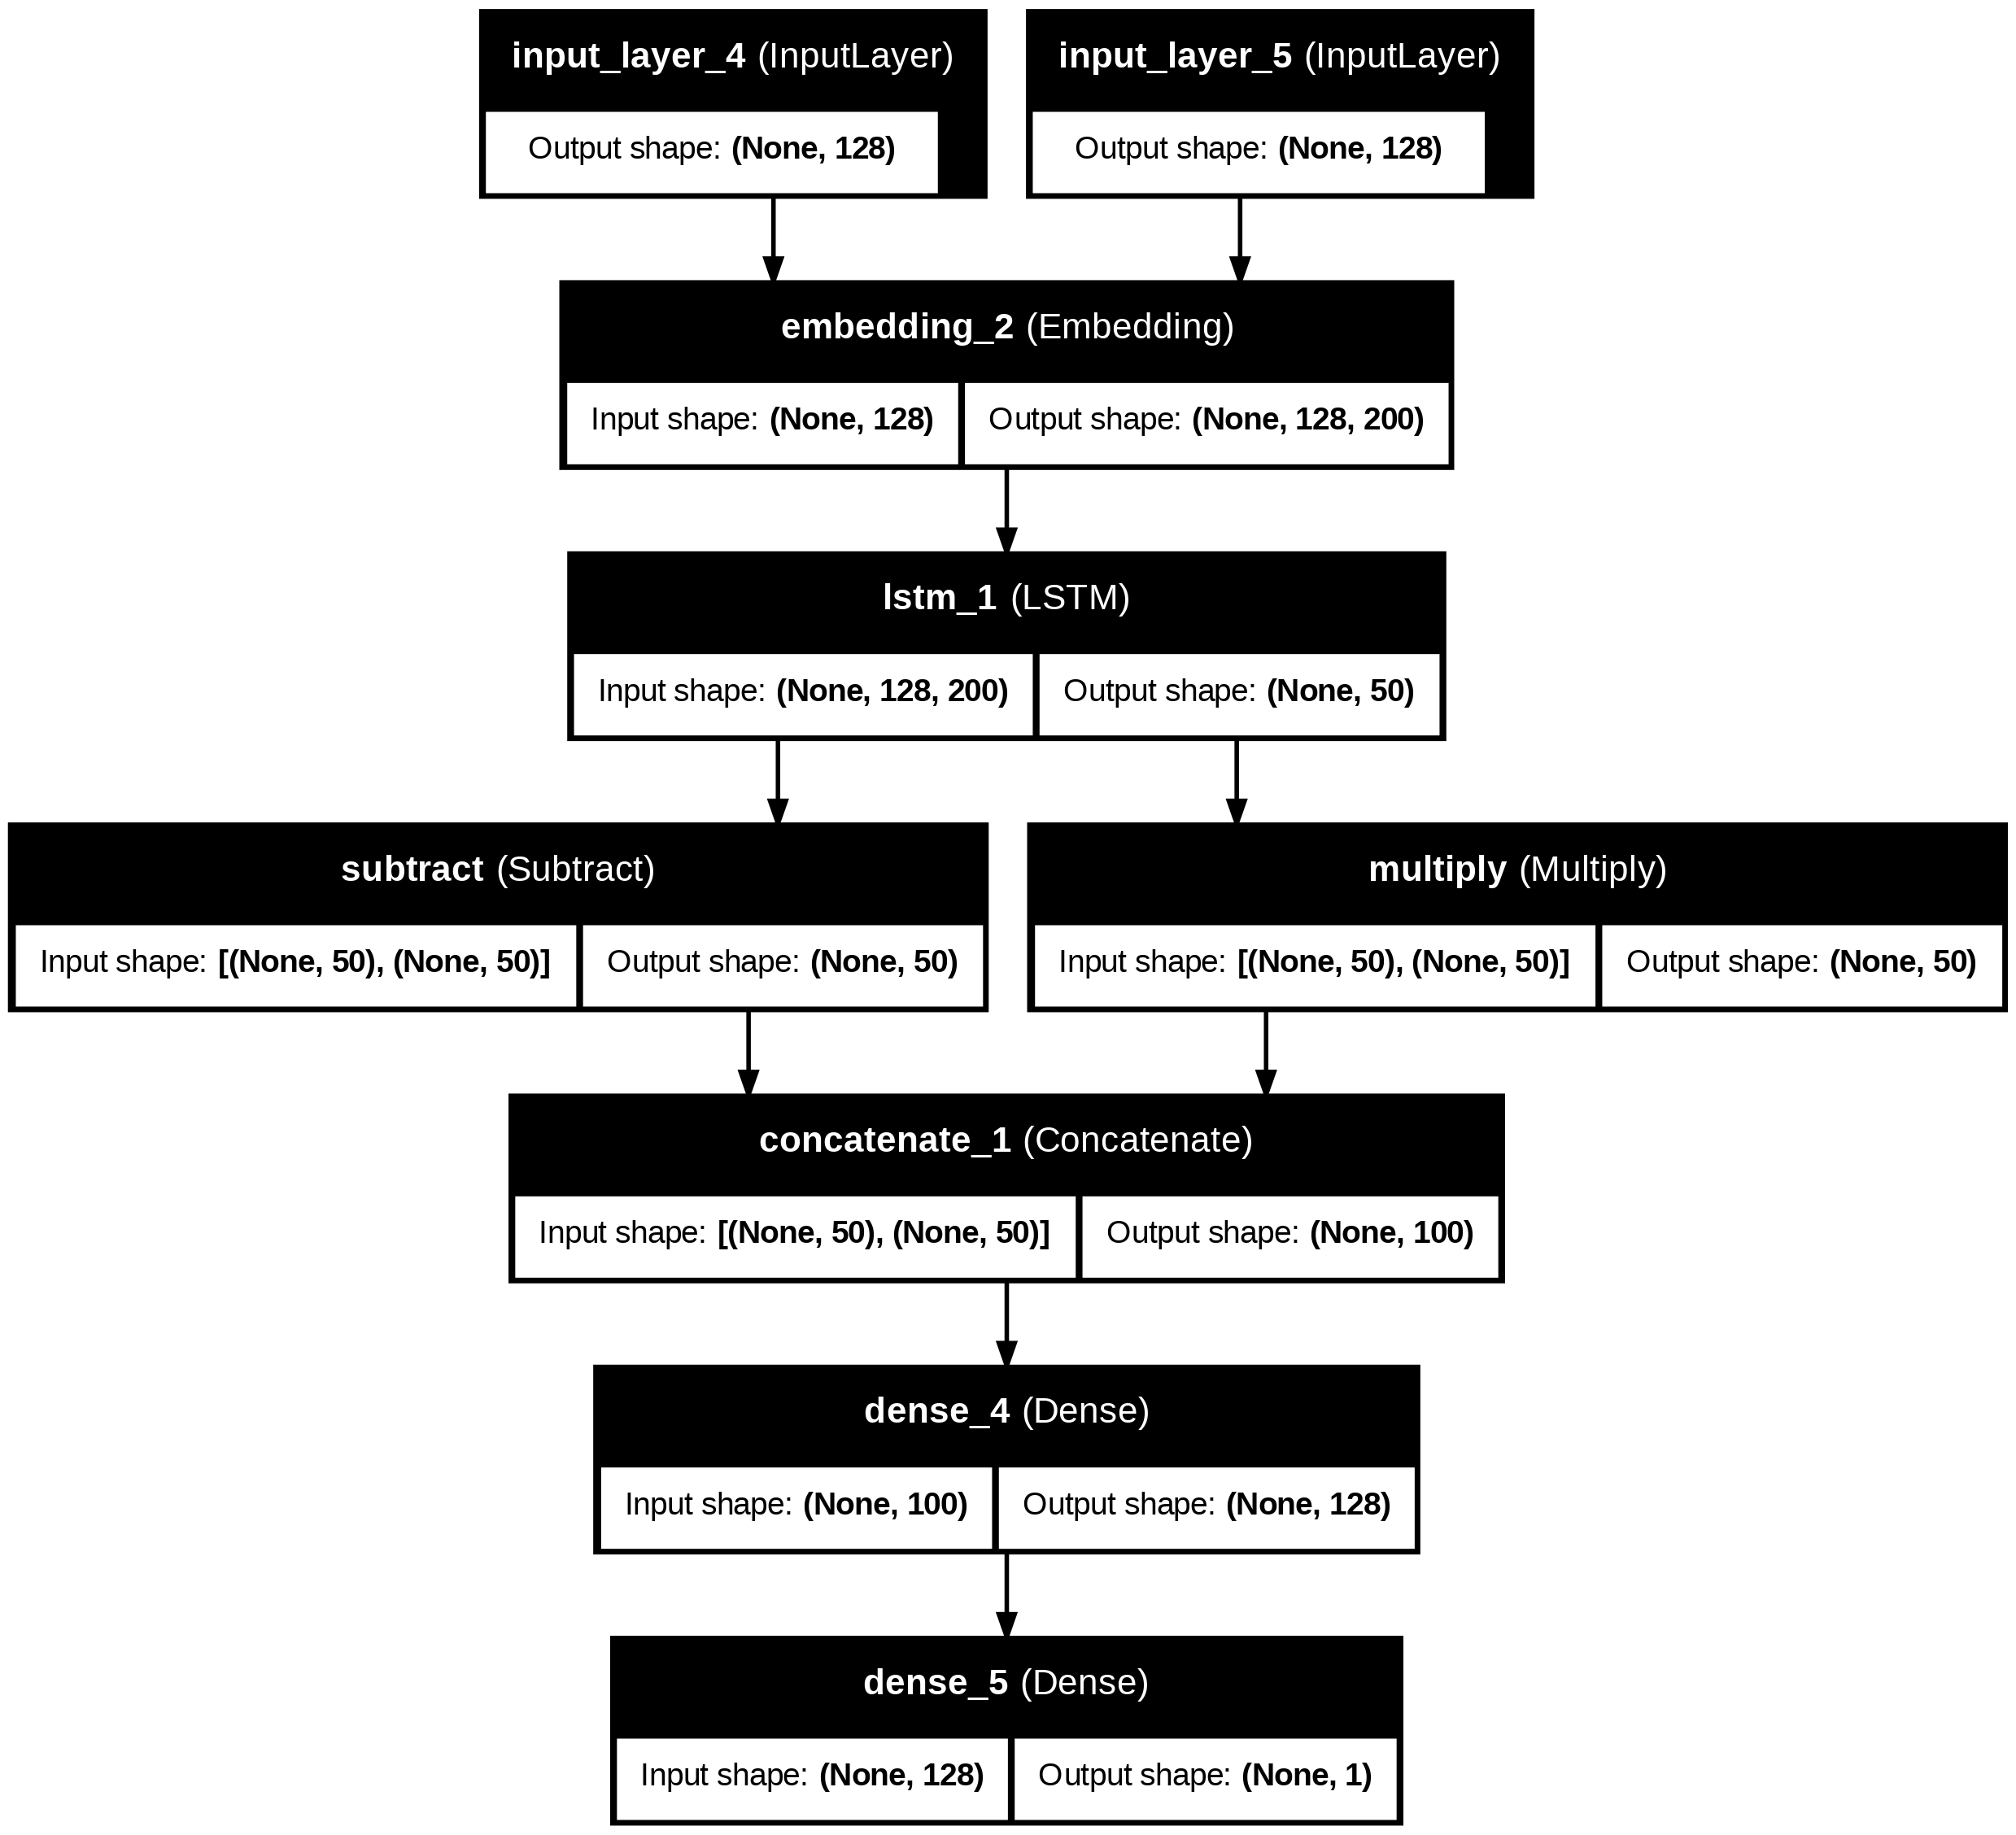

In [ ]:
plot_model(siamese_model, to_file='siamese_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train and evaluate CNN
cnn_model = build_cnn_model(vocab_size, embedding_dim, max_len, embedding_matrix)
cnn_history, cnn_report, cnn_conf_matrix = train_and_evaluate(
    cnn_model, X_train_q1, X_train_q2, y_train, X_test_q1, X_test_q2, y_test, "CNN_Model"
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6296 - loss: 0.6520 - val_accuracy: 0.6935 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7416 - loss: 0.5262 - val_accuracy: 0.6425 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8395 - loss: 0.3913 - val_accuracy: 0.6750 - val_loss: 0.7501 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9121 - loss: 0.2567 - val_accuracy: 0.6835 - val_loss: 0.6548 - learning_rate: 2.0000e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Classification Report for CNN_Model:
           Not Duplicate   Duplicate  accuracy    macro avg  weighted avg
precision       0.737814    0.600619    0.6935     0.669217      0.686846
recall          0.794749    0.522207    0.6935     0.658478      0.693500
f1-score        0.765224    0.558675    0.6935     0.661950      0.688491
support      1257.000000 

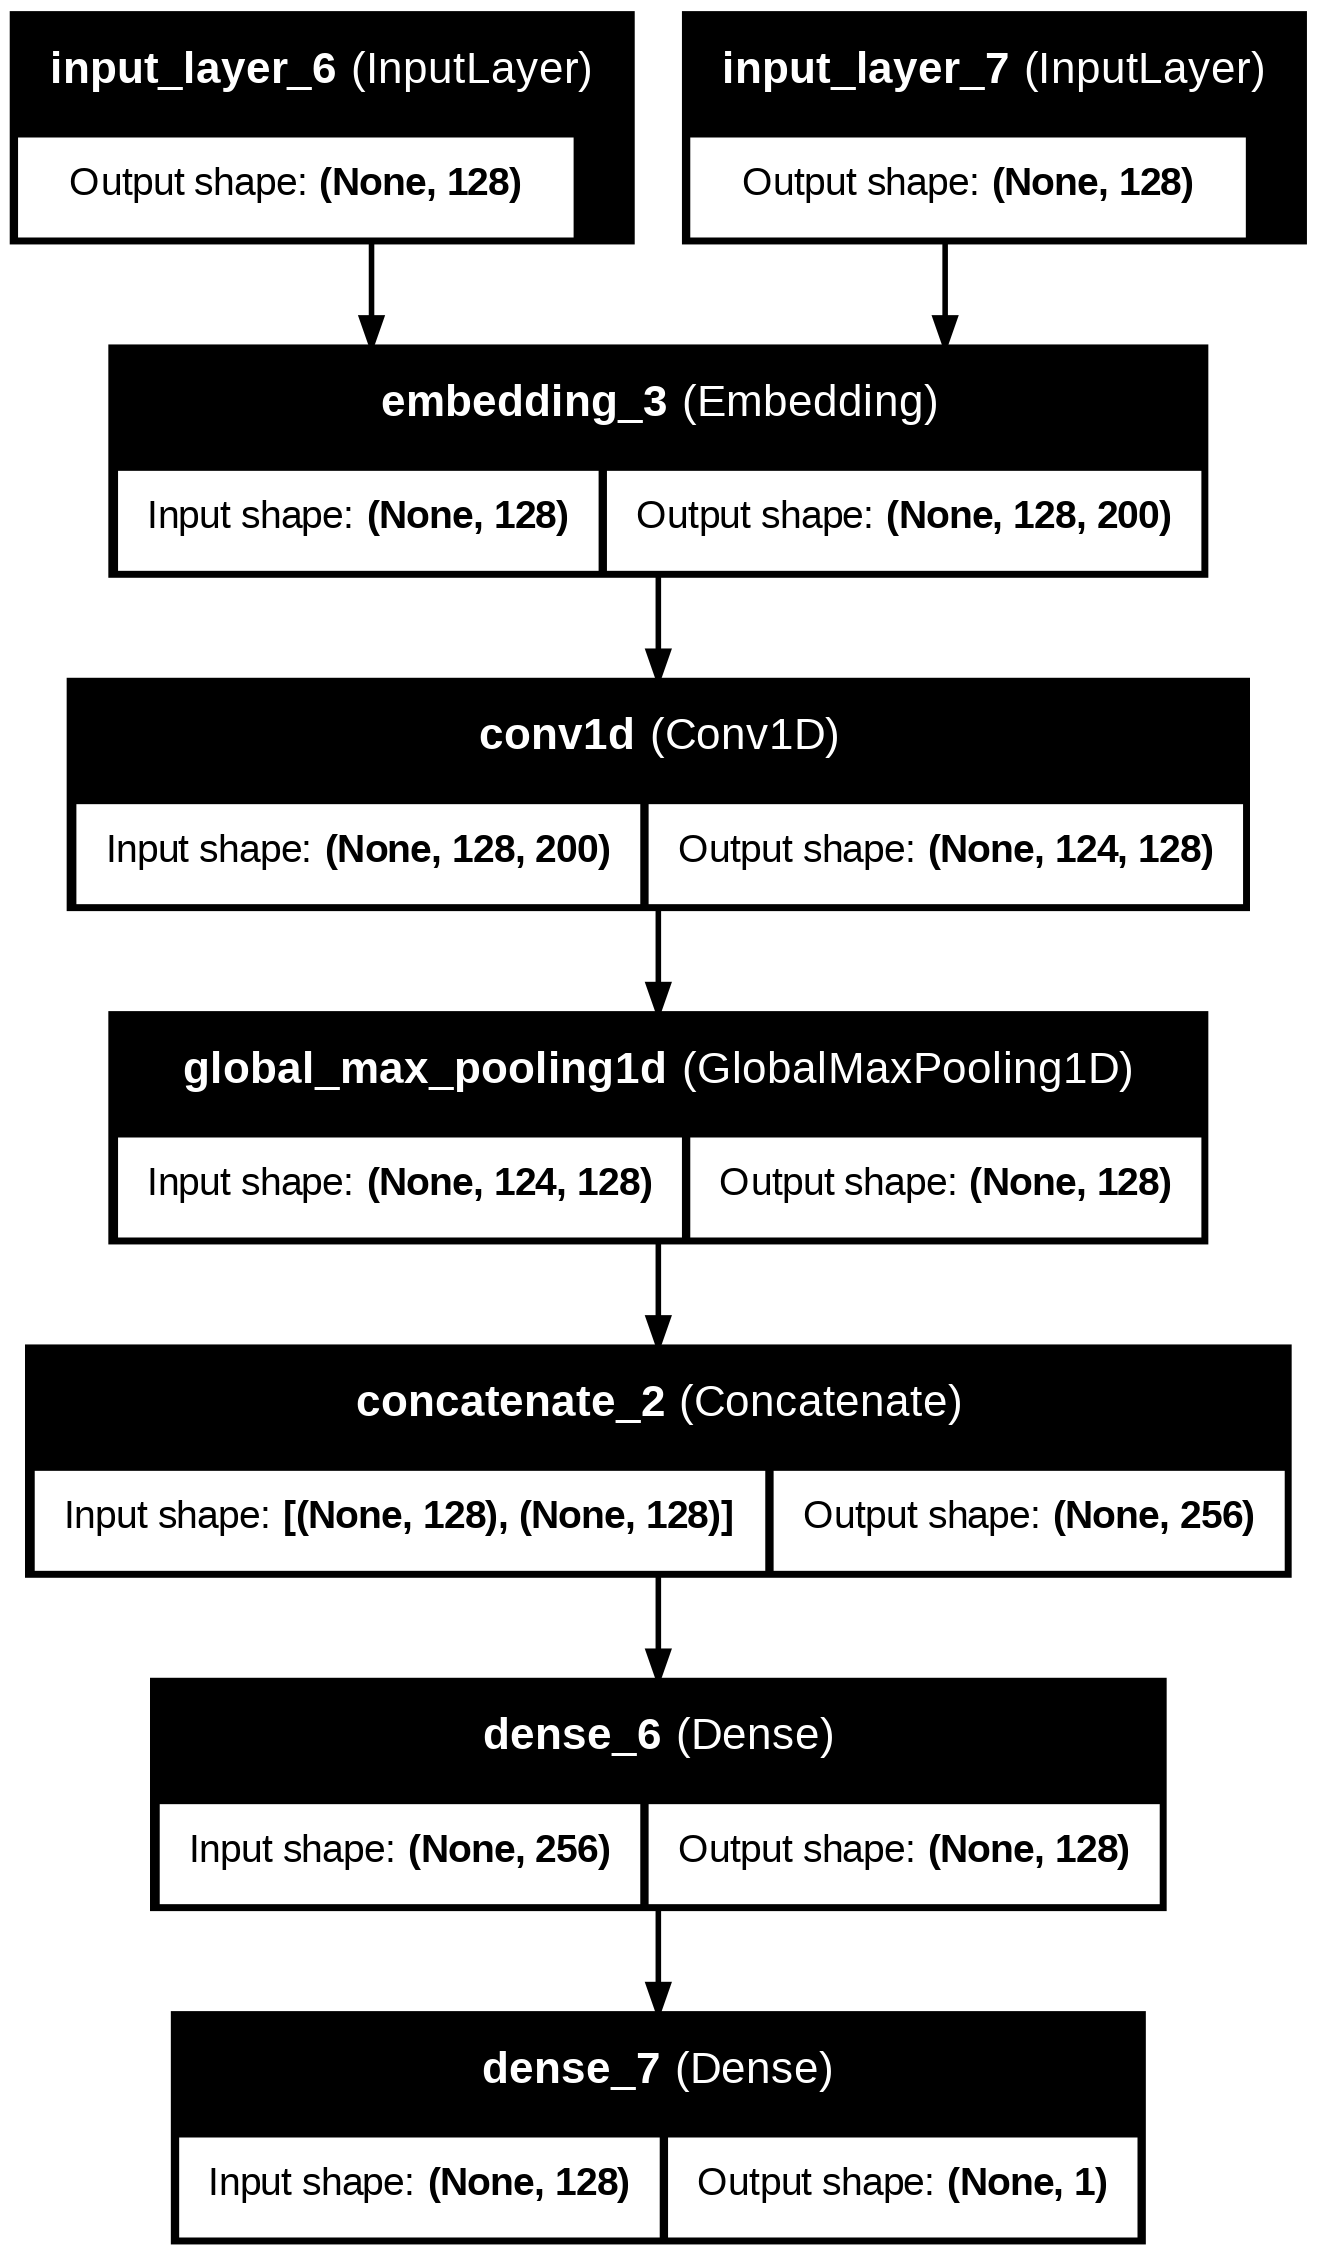

In [ ]:
plot_model(cnn_model, to_file='cnn_model_architecture.png', show_shapes=True, show_layer_names=True)

# 7. Comparing Models

In [ ]:
# Function to extract metrics for comparison
def extract_metrics(report, model_name):
    accuracy = report['accuracy']
    precision = report['Duplicate']['precision']
    recall = report['Duplicate']['recall']
    f1 = report['Duplicate']['f1-score']
    return [model_name, accuracy, precision, recall, f1]

comparison_table = pd.DataFrame(
    [extract_metrics(ffn_report, "FFN"),
     extract_metrics(bilstm_grn_report, "Bi-LSTM + GRN"),
     extract_metrics(siamese_report, "Siamese Network"),
     extract_metrics(cnn_report, "CNN"),],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

In [ ]:
# Display comparison table
print(comparison_table)

             Model  Accuracy  Precision    Recall  F1-Score
0              FFN    0.6735   0.592593  0.387618  0.468674
1    Bi-LSTM + GRN    0.7160   0.659963  0.485868  0.559690
2  Siamese Network    0.7200   0.667276  0.491252  0.565891
3              CNN    0.6935   0.600619  0.522207  0.558675


# 8. Plotting Training Metrics

In [ ]:
def plot_training_metrics(history, model_name):
    # Create a figure with two subplots arranged in one row and two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training and validation accuracy on the first subplot
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training and validation loss on the second subplot
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

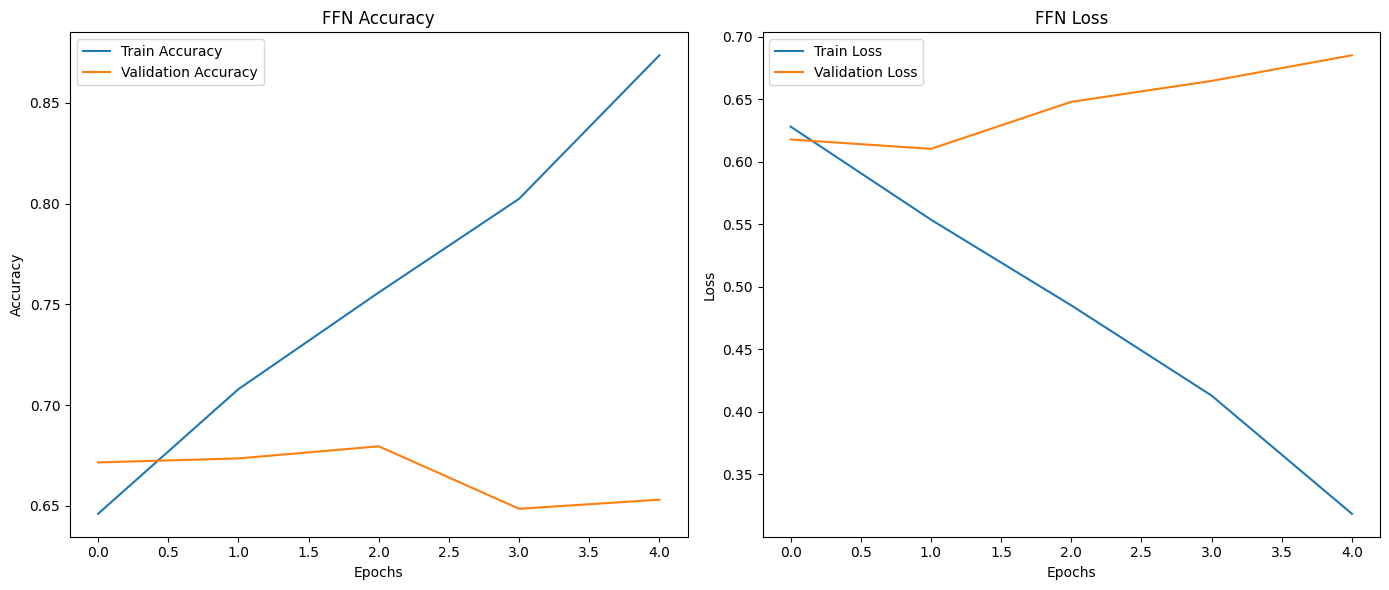

In [ ]:
plot_training_metrics(ffn_history, "FFN")

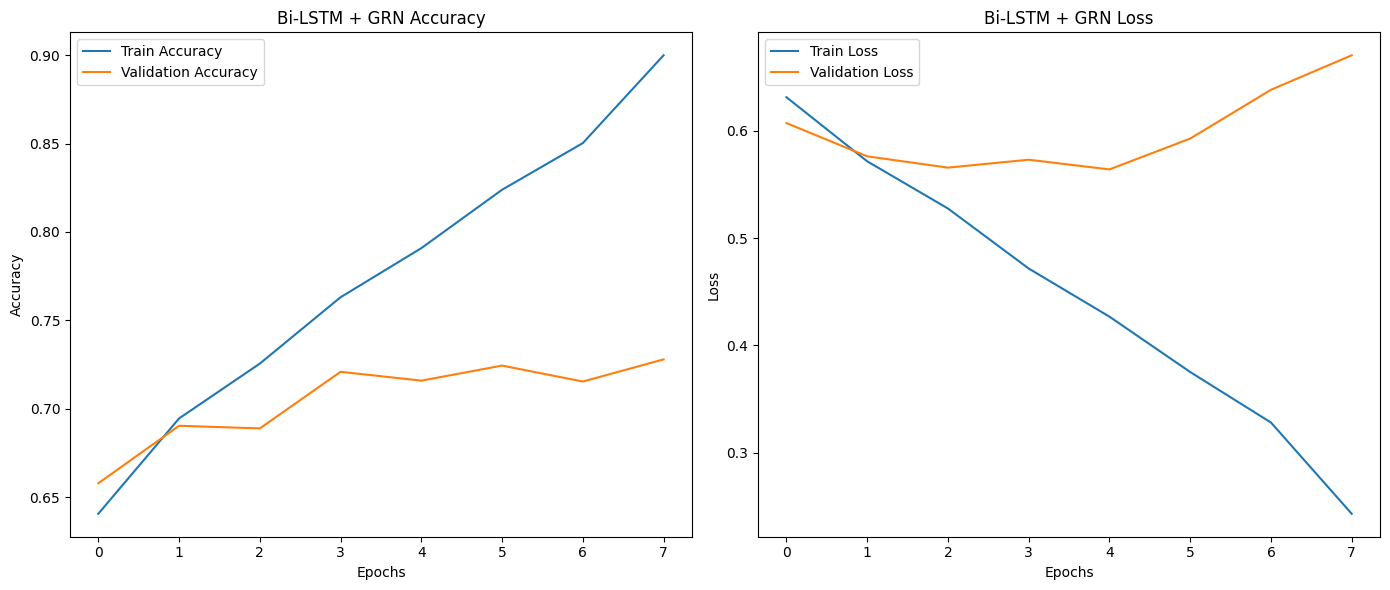

In [ ]:
plot_training_metrics(bilstm_grn_history, "Bi-LSTM + GRN")

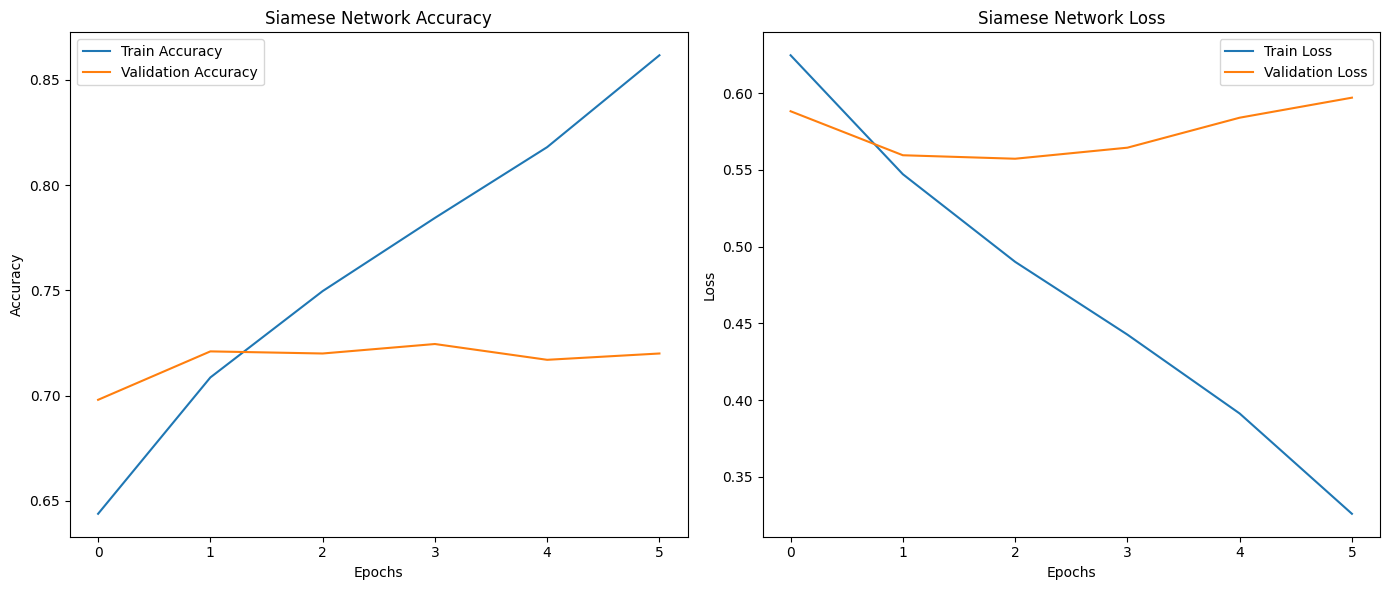

In [ ]:
plot_training_metrics(siamese_history, "Siamese Network")

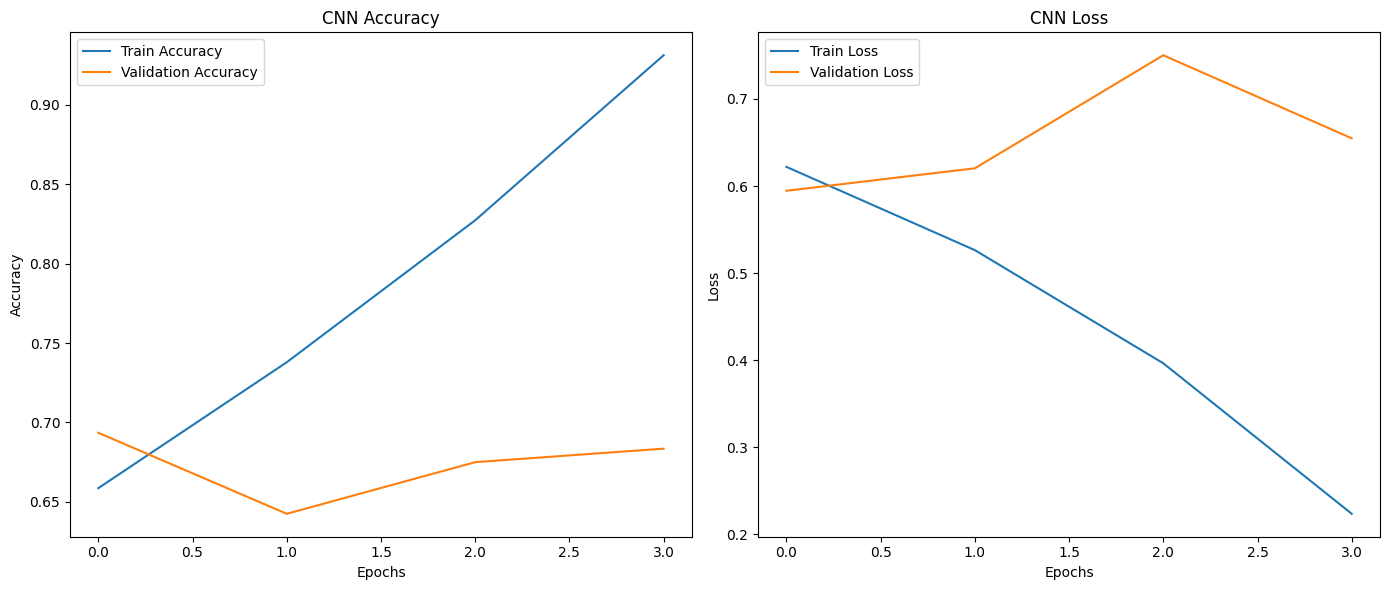

In [ ]:
plot_training_metrics(cnn_history, "CNN")